# Programming for Data Science and Artificial Intelligence

## PyTorch - Convolutional Neural Network

- [WEIDMAN] Ch7
- https://pytorch.org/tutorials/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Last class we use linear network for classifying MNIST data.  Today we shall propose CNN (Convolutional Neural Network) as a better way for dealing with image classification.

There are mainly three layers that can help dealing with images:

1. Convolutional layer
2. Max/Average pooling layer
3. BatchNorm layer
4. Dropout layer

### 1. Convolutional Layer
Let's say given a image of 14 x 14 pixels = 196 features like this.  Each data point is an array of numbers describing how dark each pixel is, where value range from 0 to 255.  These values can be normalized ranging from 0 to 1. For example, for the following digit (the digit 1), we could have:

<img src ="figures/one.png" width="250">

It is first important to define the input shape of an image, which will be <code>(input channels, image height, image width)</code>.  If we have lots of images, the input shall be <code>(batch size, input channels, image height, image width)</code>.  For our case, if it is a grayscale image, the shape is <code>(1, 14, 14)</code>.  If it is a RGB image, it shall be <code>(3, 14, 14)</code>.  If it is a CMYK, it shall be <code>(4, 14, 14)</code>.  If I define batch size as 500 (out of many more images I have), my input is <code>(500, 4, 14, 14)</code>.  (Commonly, batch size is around few hundreds).

Convolutional network works on the central concept of a convolution operation like this:

<img src ="figures/no_padding_no_strides.gif" width="150">

Mathematically, it looks like this:

Let's say we have a 5 x 5 input image $I$ of channel 0 of batch 0:

$$ I = \begin{bmatrix}
i_{11} & i_{12} & i_{13} & i_{14} & i_{15}
\\
i_{21} & i_{22} & i_{23} & i_{24} & i_{25}
\\
i_{31} & i_{32} & i_{33} & i_{34} & i_{35}
\\
i_{41} & i_{42} & i_{43} & i_{44} & i_{45}
\\
i_{51} & i_{52} & i_{53} & i_{54} & i_{55}
\end{bmatrix}
$$

Each of this pixel may represent the brightness ranging from 0 to 255.  Or if normalized, shall be 0 to 1.

If we define a 3 x 3 patch which we commonly called **weights (W)** or in computer vision, we called **filters/kernels** like this (*we shall called filters in this lecture note for simplicity*) :

$$ W = \begin{bmatrix}
w_{11} & w_{12} & w_{13}
\\
w_{21} & w_{22} & w_{23}
\\
w_{31} & w_{32} & w_{33}
\end{bmatrix}
$$

Let's say we are scanning the middle of the image, then the output feature would be (we'll denote this as $o_{33}$):

$$o_{33} = w_{11} * i_{22} + w_{12} * i_{23} + w_{13} * i_{24} + \
           w_{21} * i_{32} + w_{22} * i_{32} + w_{23} * i_{34} + \
           w_{32} * i_{43} + w_{33} * i_{44}$$
           
This will result in one output feature called **feature map**.  Of course, we may add bias to it and then will be fed through an activation function.

Actual feature maps look like this.  Each feature map is a output of a single training example and convolve each kernel over the sample.    In simple words, if we have $k$ filters, then we have $k$ feature maps.  They represent the activation part corresponding to the kernels.

<img src ="figures/feature-map2.png" width="450">

In a convolution operation, there are 3 main hyperparameters to fine tune - (1) filter size, (2) padding, and (3) stride.

#### A. Filters

1. **How the filters look like?**.  It turns out that each filter actually detect the presence of certain visual pattern.  For example, this filter below detects whether there is an edge at that location of the image.  There are also other similar filters detecting corners, lines, etc.  Check out https://setosa.io/ev/image-kernels/  and try changing the values

$$ w = \begin{bmatrix}
0 & 1 & 0
\\
1 & -4 & 1
\\
0 & 1 & 0
\end{bmatrix}
$$

Real filters can look like this.  They may look somewhat random at first glance, but we can see that clear structure being learned in most kernels. For example, filters 3 and 4 seem to be learning diagonal edges in opposite directions, and other capture round edges or enclosed spaces:

<img src ="figures/kernels.png" width="200">

However, **it is important to note that we DON'T need to decide the filters** to use.  We can simply feed a random generated filter, and it is the job of CNN to learn these filters.   These learned filters will learn what features are most efficient for the classification process.

**What is the shape of filters?**.  For each image, we can apply multiple filters, depending on how many output channels we want.  Let's say the input channel is 3, and we want the output channel to 64, then we apply a filter of size <code>(3, 64, filter width, filter height)</code>.  How do we know how many output channel to use? The answer is we don't know...we just try and see what works.  More filter allows the network to look at more patterns.

**What should be the filter size?**  If we use a 3 x 3 filter, each pixel got 8 neighboring information.  On the other hand, if we we use big filter like 9 x 9, then we got 80 neighboring information.  Typical size is 3 and 5.


#### B. Padding

2. **How should we convolve the edges?**. Recall this image:

<img src ="figures/no_padding_no_strides.gif" width="150">

It has 4 x 4 pixels = 16 features.  But after convolution, we only got 2 x 2 pixels = 4 features left.  Is that good?  There are no correct answers here but we are quite sure that we lose some information.  One way is address this is **padding**, where we can enlarge the input image by padding the surroundings with zeros.  How much?  Padding until we get the original size or larger size, for example, like this.  The below put zero padding around which result the output features to be the same size as input features.

<img src ="figures/same_padding_no_strides.gif" width="150">

The below put even more padding which pad to make sure each single pixel is convoluted (full padding), which result the output features to be even large

<img src ="figures/full_padding_no_strides.gif" width="150">

#### C. Strides

3. **How many step we should take to slide our filter? Skip 2?** Should we shift 1 step per convolution, or 2 steps, or how many steps.  **In fact, it really depends on how detail you want it to be.  But defining bigger steps reduce the feature size and thus reduce the computation time.**  Bigger step is like human scanning picture more roughly but can reduce the computation time....whether to use it is something to be experimented though. 

In computer vision, we called this step as **stride**.  Example is like this:

**No padding with stride of 2**

<img src ="figures/no_padding_strides.gif" width="150">

**Padding with stride of 2**

<img src ="figures/padding_strides.gif" width="150">

Actual image convolution can look like this (with stride 1 and no padding):

<img src ="figures/conv.gif" width="400">

The convoluted image may look like this (nothing relate with the above matrix though):

<img src ="figures/convimages.png" width="400">

**The formula to be used to measure the padding value to get the spatial size of the input and output volume to be the same with stride 1** is

$$ \frac{K-1}{2} $$

where $K$ is the filter size.

This means that if our image is size $24 * 24$, and the filter size is $3 x 3$, then our $K$ has size 3 so the padding should be $(3-1)/2 = 1$, then we need to add **a border of one pixel valued 0 around the outside of the image**, which would result in the input image of size $26 * 26$

#### D. Shape

4. **What would be the shape of the output matrix?**

The output shape (denote as $O$) depend on the stride (denote as $S$), padding (denote as $P$), filter size (denote as $F$) as well as the input width and height (denote as $I$). $O$ can be calculated with the formula as follows:

$$O = \frac{I-F+2P}{S} + 1$$

In this case (code below), if our I is 28, F is 5, P is 2, and S is 1 then the width/height is 28

In conclusion, 

- The input will have a 4D shape of <code>(batch size, input channels, input height, input width)</code>

- The output will have a 4D shape of <code>(batch size, output channels, output height, output width)</code>

- The convolutional filters will have 4D shape of <code>(input channels, output channels, filter height, filter width)</code>

**Note: The order does not matter and it depends on the python library you use but these four dimensions always exist in CNN.**

### 2. Max/Average Pooling Layer

Talking about **reducing computation time**, a common way is to perform a **pooling layer** which simply downsample the image by average a set of pixels, or by taking the maximum value.  If we define a pooling size of 2, this involves mapping each 2 x 2 pixels to one output, like this:

<img src ="figures/pooling.png" width="150">

Nevertheless, pooling has a really big downsides, i.e., it basically lose a lot of information.  Compared to strides, strides simply scan less but maintain the same resolution but pooling simply reduce the resolution of the images....As Geoffrey Hinton said on Reddit AMA in 2014 - **The pooling operation used in CNN is a big mistake and the fact that it works so well is a disaster**.  In fact, in most recent CNN architectures like ResNets, it uses pooling very minimially or not at all.

### 3. BatchNorm Layer

Batch norm is nothing other than normalize samples within the batch.  That is, minus the mean of features within the batch.  This helps with unstable gradients in SGD. Note that the output size does not change from input size after BatchNorm.

<img src ="figures/batchnorm.png" width="300">

<img src ="figures/landscape.png" width="500">


### 4. Dropout Layer

This is a layer of arbitrarily removing some values in your data.  By randomly removing data in each iteration, you make the neural network more robust against overfitting, because it needs to learn to fight with incomplete data.

For example, say we have a vector of $x = {1, 2, 3, 4, 5}$.  Let's set $p=0.2$ which means 20\% of data will be turn to 0.  In training mode, $x_\text{train} = {1, 0, 3, 4, 5}$ ; do not confuse why I turn off 2 and not others, I just turn 20\% off randomly.  In evaluation mode, we turn off dropout, but to make sure the distribution remains similar, we multiply the values by $1 - 0.2 = 0.8$, which becomes $x_\text{inference} = {0.8, 1.6, 2.4, 3.2, 4.0}$

### Demo

https://www.cs.ryerson.ca/~aharley/vis/conv/

## 1. ETL: Load the MNIST dataset
PyTorch makes the MNIST train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.

In [2]:
transform = transforms.ToTensor() # Pytorch transformation to tensor

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_data, [50000, 10000])

test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Create loaders

In [5]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=10, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=10, shuffle=True)

In [6]:
len(train_loader)

5000

## 2. Define a convolutional model

In the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28 images), hidden layers of 120 and 84 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take.</strong><br>

1. Extend the base Module class:
   
<tt><font color=black>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter, and set the step size to 1.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
The second layer will take our 6 input channels and deliver 16 output channels.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Set up the fully connected layers with <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br>The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be 
$\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to 5 pixels per side.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>
See below for a more detailed look at this step.<br><br>

4. Define the forward method.<br><br>Activations can be applied to the convolutions in one line using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a> and pooling is done using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>
<tt><font color=black>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
</font></tt>Flatten the data for the fully connected layers:<br><tt><font color=black>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the convolutional layers</strong> (this code is for illustration purposes only.)</div>

In [7]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [8]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break
    
X_train.shape    

torch.Size([1, 28, 28])

In [9]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [10]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [11]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [12]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [13]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [14]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


<div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>

Now let's run the code.

In [15]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [16]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{align}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{align}$<br>

In [17]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [18]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [19]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[ 0.2548,  0.2767, -0.0781],
          [ 0.3062, -0.0730,  0.0673],
          [-0.1623,  0.1958,  0.2938]]],


        [[[-0.2445,  0.2897,  0.0624],
          [ 0.2463,  0.0451,  0.1607],
          [-0.0471,  0.2570,  0.0493]]],


        [[[-0.1556,  0.0850, -0.1536],
          [-0.0391, -0.1354,  0.2211],
          [-0.2631, -0.1537, -0.0941]]],


        [[[-0.2004,  0.0315, -0.3292],
          [ 0.3010, -0.2832,  0.2573],
          [ 0.0555, -0.1082,  0.2060]]],


        [[[ 0.0520,  0.2693,  0.0364],
          [-0.1051,  0.0896, -0.0904],
          [ 0.1403,  0.2976,  0.1927]]],


        [[[-0.1457,  0.1924,  0.0596],
          [ 0.1693, -0.2032, -0.3300],
          [-0.1288, -0.2557,  0.2735]]]], requires_grad=True)
Parameter containing:
tensor([ 0.0960,  0.1381,  0.1054, -0.0058,  0.2609, -0.2368],
       requires_grad=True)
Parameter containing:
tensor([[[[ 0.0086, -0.0929,  0.0420],
          [-0.0469,  0.0417, -0.0284],
          [ 0.1129, -

### Define loss function & optimizer

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model
This time we'll feed the data directly into the model without flattening it first.

In [21]:
import time
start_time = time.time()

epochs = 5
train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the validation batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):

            # Apply the model
            yhat_val = model(X_val)

            # Tally the number of correct predictions
            predicted = torch.max(yhat_val.data, 1)[1] 
            tst_corr += (predicted == y_val).sum()
            
    loss = criterion(yhat_val, y_val)
    val_losses.append(loss)
    val_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.61011904  accuracy:  78.650%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.03751423  accuracy:  85.525%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.24703658  accuracy:  88.722%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.00395802  accuracy:  90.525%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.47399369  accuracy:  91.677%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00279189  accuracy:  92.564%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.05014556  accuracy:  93.200%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.01009761  accuracy:  93.677%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00428647  accuracy:  97.300%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.02088502  accuracy:  97.367%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.05341913  accuracy:  97.422%
epoch:  1  batch: 2400 [ 24000/60000]  loss: 0.00315051  accuracy:  97.600%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.00257667  accuracy:  97.693%
epoch:  1  b

### Plot the loss and accuracy comparisons

In [22]:
train_losses = [loss.item() for loss in train_losses]
val_losses   = [loss.item() for loss in val_losses]

In [23]:
train_losses

[0.006417757831513882,
 0.12822018563747406,
 0.0017054991330951452,
 0.017299529165029526,
 0.00046517682494595647]

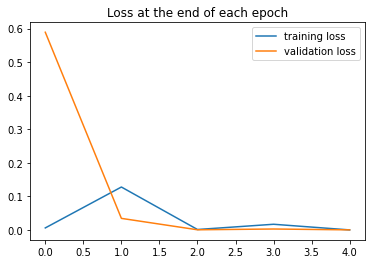

In [24]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [25]:
val_losses

[0.5892243385314941,
 0.03484190255403519,
 0.0008685365319252014,
 0.0031729943584650755,
 0.000636119453702122]

While there may be some overfitting of the training data, there is far less than we saw with the ANN model.

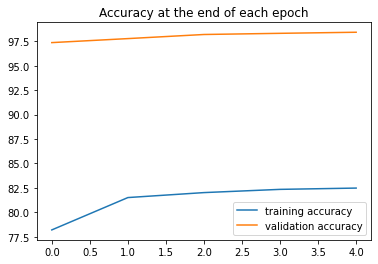

In [26]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in val_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [27]:
train_correct[0]

tensor(46923)

In [28]:
len(train_loader)

5000

In [29]:
temp = 100*train_correct[0]/(len(train_loader)*10)
temp.numpy() # converts tensor to numpy array

array(93.846, dtype=float32)

## 3. Inference / Testing

In [30]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [31]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9861/10000 =  98.610%


Recall that our [784,120,84,10] ANN returned an accuracy of 97.25% after 10 epochs. And it used 105,214 parameters to our current 60,074.

## Display the confusion matrix

In [32]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 975    2    0    0    0    1    3    0    3    0]
 [   0 1129    0    0    1    0    5    5    1    1]
 [   1    1 1029    3    1    0    1    7    3    0]
 [   0    1    0 1002    0   12    0    1    4    4]
 [   0    0    0    0  964    0    7    0    0    2]
 [   0    0    0    3    0  870    3    0    0    5]
 [   1    0    0    0    1    1  935    0    0    0]
 [   1    1    2    2    1    0    0 1008    0    0]
 [   2    1    1    0    4    4    4    2  962   10]
 [   0    0    0    0   10    4    0    5    1  987]]


## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [33]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

139

In [34]:
# Display the first 10 index positions
misses[:10]

array([ 184,  247,  320,  339,  340,  412,  445,  448,  449,  740])

In [35]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

In [36]:
row

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

Index: [ 184  247  320  339  340  412  445  448  449  740  813  829]
Label: [   8    4    9    6    5    5    6    9    3    4    9    4]
Guess: [   3    2    8    5    3    3    0    8    5    9    8    8]


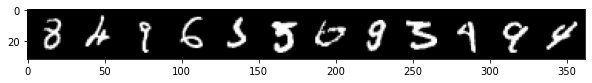

In [37]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

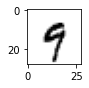

In [38]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [39]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())
# model.eval() vs torch.no_grad()
# https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615

Predicted value: 9
